# Проектная работа: "Определение перспективного тарифа для телеком-компании"

**Описание проекта**

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов**

**Тариф «Смарт»**
Ежемесячная плата: 550 рублей
Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 3 рубля
сообщение: 3 рубля
1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
Ежемесячная плата: 1950 рублей
Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
Стоимость услуг сверх тарифного пакета:
минута разговора: 1 рубль
сообщение: 1 рубль
1 Гб интернет-трафика: 150 рублей

In [1]:
import pandas as pd
import copy
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy import stats as st
import numpy as np
from functools import reduce

### Шаг 1. Откройте файл с данными и изучите общую информацию

Изучим файл с данными о пользователях

In [2]:
users = pd.read_csv('/datasets/users.csv')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [3]:
display(users.head())
display(users.tail())

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart
499,1499,35,NaN,Пермь,Гектор,Корнилов,2018-09-27,smart


In [4]:
display(users.describe().T)

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


Изучим таблицу с данными о звонках

In [5]:
calls = pd.read_csv('/datasets/calls.csv')
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [6]:
display(calls.head())
display(calls.tail())

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,id,call_date,duration,user_id
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499
202606,1499_219,2018-12-14,19.62,1499


In [7]:
display(calls.describe().T)

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


Таблица messages

In [8]:
messages = pd.read_csv('/datasets/messages.csv')
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
display(messages.head())
display(messages.tail())

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,id,message_date,user_id
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499
123035,1499_183,2018-11-16,1499


In [10]:
display(calls.describe().T)

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


Тарифы

In [11]:
tariffs = pd.read_csv('/datasets/tariffs.csv')
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
display(tariffs)

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Интернет

In [13]:
internet = pd.read_csv('/datasets/internet.csv')
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [14]:
display(internet.head())
display(internet.tail())

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,Unnamed: 0,id,mb_used,session_date,user_id
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499
149395,149395,1499_156,544.37,2018-10-26,1499


In [15]:
display(internet.describe().T)

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


**Описание данных**


**Таблица users (информация о пользователях):**
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tarif — название тарифного плана

**Таблица calls (информация о звонках):**
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

**Таблица messages (информация о сообщениях):**
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

**Таблица internet (информация об интернет-сессиях):**
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

**Таблица tariffs (информация о тарифах):**
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

#### Вывод

Мы имеем данные 500 клиентов, предварительно можно утверждать, что, данных достаточно для ответа на поставленные вопросы. Но встречаются пропуски в данных, также потребуется заменить тип данных у столбцов с датой, и округлить значения для подсчета выручки от звонков и потребляемого траффика.

Чтобы двигаться дальше, нужно устранить проблемы в данных.

### Шаг 2. Подготовка данных

Изменим тип данных столбцов с датой и временем

In [16]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

Округлим длительность звонков

In [17]:
#calls['duration'] = calls['duration'].apply(np.ceil)
calls['duration'] = np.ceil(calls['duration'])

In [19]:
# добавим столбец со значением месяца
calls['month'] = calls['call_date'].dt.month
print('Количество звонков с длительностью, равной нулю:', calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с длительностью, равной нулю: 39613


In [20]:
messages['month'] = messages['message_date'].dt.month

По условию задания звонки с нулевой продолжительностью - пропущенные звонки, поэтому их не нужно удалять.

Посчитаем для каждого пользователя:
1. количество сделанных звонков и длительность разговора по месяцам;
2. количество отправленных сообщений по месяцам;
3. объем израсходованного интернет-трафика по месяцам;
4. помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [21]:
# скомбинируем уникальное имя для каждого пользователя
users['unique_name'] = users['city'] + users['first_name'] + users['last_name']

In [22]:
# сводная таблица по звонкам
calls_grouped = calls.merge(users, on='user_id', how='inner').pivot_table(values=['unique_name', 'duration'], 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count', 'duration': 'sum'})
calls_grouped.columns = ['duration', 'calls']

In [23]:
# сводная таблица по сообщениям
messages['month'] = messages['message_date'].dt.month
messages_grouped = messages.merge(users, on='user_id', how='inner').pivot_table(values='unique_name', 
                       index=['user_id', 'month'], 
                       aggfunc={'unique_name': 'count'})
messages_grouped.columns = ['messages']

In [24]:
# сводная таблица по интернет-трафику
internet['month'] = internet['session_date'].dt.month
internet_grouped = internet.merge(users, on='user_id', how='inner').pivot_table(values='mb_used', 
                       index=['user_id', 'month'], 
                       aggfunc={'mb_used': 'sum'})
internet_grouped.columns = ['gb_used']
internet_grouped['gb_used']=np.ceil(internet_grouped['gb_used']/1024)

In [25]:
# объединяем все три сводные таблицы в одну
dataframes = [calls_grouped, messages_grouped, internet_grouped]
df = reduce(lambda left,right: pd.merge(left,right,on=['user_id', 'month'], how='outer'), dataframes)
display(df.head(15))

duration  calls  messages  gb_used
user_id month                                    
1000    5         159.0   22.0      22.0      3.0
        6         172.0   43.0      60.0     23.0
        7         340.0   47.0      75.0     14.0
        8         408.0   52.0      81.0     14.0
        9         466.0   58.0      57.0     15.0
        10        350.0   57.0      73.0     15.0
        11        338.0   43.0      58.0     15.0
        12        333.0   46.0      70.0     10.0
1001    11        430.0   59.0       NaN     18.0
        12        414.0   63.0       NaN     14.0
1002    6         117.0   15.0       4.0     11.0
        7         214.0   26.0      11.0     18.0
        8         289.0   42.0      13.0     20.0
        9         206.0   36.0       4.0     17.0
        10        212.0   33.0      10.0     14.0

In [26]:
# Заменим пропущенные значения на нули
df.loc[df['duration'].isna(), 'duration'] = 0
df.loc[df['messages'].isna(), 'messages'] = 0
df.loc[df['gb_used'].isna(), 'gb_used'] = 0

In [27]:
# добавим наименование используемого тарифа и город для каждого пользователя
for user in df.index:
    df.loc[user, 'tariff'] = users.loc[user[0]-1000, 'tariff']
    df.loc[user, 'city'] = users.loc[user[0]-1000, 'city']

**Описание тарифов**

**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: минута разговора: 3 рубля, сообщение: 3 рубля, 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета: минута разговора: 1 рубль, сообщение: 1 рубль, 1 Гб интернет-трафика: 150 рублей

In [28]:
# функция подсчета выручки с каждого пользователя в месяц
def det_revenue(row):
    messages = row['messages']
    gb_used = row['gb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    
    if tariff == 'smart':
        extra_duration = duration - tariffs.loc[0, 'minutes_included']
        extra_gb = gb_used - (tariffs.loc[0, 'mb_per_month_included']/1024)
        extra_messages = messages - tariffs.loc[0, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[0, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[0, 'rub_per_gb']) * extra_gb + 
                   tariffs.loc[0, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[0, 'rub_monthly_fee']
                  ) 
    else:
        extra_duration = duration - tariffs.loc[1, 'minutes_included']
        extra_gb = gb_used - (tariffs.loc[1, 'mb_per_month_included']/1024)
        extra_messages = messages - tariffs.loc[1, 'messages_included']
        
        if extra_duration < 0: extra_duration = 0
        if extra_gb < 0: extra_gb = 0
        if extra_messages < 0: extra_messages = 0
        
        return (tariffs.loc[1, 'rub_per_message'] * extra_messages + 
                   (tariffs.loc[1, 'rub_per_gb']) * extra_gb + 
                   tariffs.loc[1, 'rub_per_minute'] * extra_duration + 
                   tariffs.loc[1, 'rub_monthly_fee']
                  )

df['revenue'] = df.apply(det_revenue, axis=1)
df.head(10)

duration  calls  messages  gb_used tariff       city  revenue
user_id month                                                               
1000    5         159.0   22.0      22.0      3.0  ultra  Краснодар   1950.0
        6         172.0   43.0      60.0     23.0  ultra  Краснодар   1950.0
        7         340.0   47.0      75.0     14.0  ultra  Краснодар   1950.0
        8         408.0   52.0      81.0     14.0  ultra  Краснодар   1950.0
        9         466.0   58.0      57.0     15.0  ultra  Краснодар   1950.0
        10        350.0   57.0      73.0     15.0  ultra  Краснодар   1950.0
        11        338.0   43.0      58.0     15.0  ultra  Краснодар   1950.0
        12        333.0   46.0      70.0     10.0  ultra  Краснодар   1950.0
1001    11        430.0   59.0       0.0     18.0  smart     Москва   1150.0
        12        414.0   63.0       0.0     14.0  smart     Москва    550.0

In [29]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1476, 4)
Data columns (total 7 columns):
duration    3214 non-null float64
calls       3174 non-null float64
messages    3214 non-null float64
gb_used     3214 non-null float64
tariff      3214 non-null object
city        3214 non-null object
revenue     3214 non-null float64
dtypes: float64(5), object(2)
memory usage: 369.6+ KB


,count,mean,std,min,25%,50%,75%,max
duration,3214.0,451.244866,241.909978,0.0,282.0,443.0,589.0,1673.0
calls,3174.0,63.833333,32.678036,1.0,41.0,63.0,83.0,244.0
messages,3214.0,38.281269,36.148326,0.0,9.0,30.0,57.0,224.0
gb_used,3214.0,17.299004,7.400584,0.0,13.0,17.0,21.0,49.0
revenue,3214.0,1529.076229,798.251091,550.0,750.0,1653.5,1950.0,6770.0


#### Вывод

Мы подготовили рабочий датафрейм, объединящий данные по пользователям,и распределенным по месяцам использованные услуги по каждому тарифу. 

### Шаг 3. Проанализируйте данные

Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Разделим датафрейм на два для анализа тарифов Smart и Ultra.

In [30]:
df_smart=df.query('tariff == "smart"')
df_ultra=df.query('tariff == "ultra"')

Посмотрим общую информацию по статистике использования услуг для пользователей обоих тарифов

In [31]:
df_smart.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,2229.0,417.934948,190.313730,0.0,282.0,422.0,545.0,1435.0
calls,2223.0,58.621233,25.796101,1.0,40.0,60.0,76.0,198.0
messages,2229.0,33.384029,28.227876,0.0,10.0,28.0,51.0,143.0
gb_used,2229.0,16.328847,5.747061,0.0,13.0,17.0,20.0,38.0
revenue,2229.0,1289.973531,818.404367,550.0,550.0,1023.0,1750.0,6770.0


In [32]:
df_ultra.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,985.0,526.623350,317.606098,0.0,284.0,518.0,752.0,1673.0
calls,951.0,76.016824,42.403348,1.0,43.0,75.0,105.0,244.0
messages,985.0,49.363452,47.804457,0.0,6.0,38.0,79.0,224.0
gb_used,985.0,19.494416,9.853511,0.0,12.0,19.0,27.0,49.0
revenue,985.0,2070.152284,376.187114,1950.0,1950.0,1950.0,1950.0,4800.0


In [33]:
variance_smart_duration = np.var(df_smart['duration'])
print('Дисперсия длительности разговоров пользователей тарифа Смарт', variance_smart_duration)
variance_smart_gb_used = np.var(df_smart['gb_used'])
print('Дисперсия траффика пользователей тарифа Смарт', variance_smart_gb_used)
variance_smart_messages = np.var(df_smart['messages'])
print('Дисперсия колличества сообщений пользователей тарифа Смарт', variance_smart_messages)

Дисперсия длительности разговоров пользователей тарифа Смарт 36203.06665209469
Дисперсия траффика пользователей тарифа Смарт 33.013887454837445
Дисперсия колличества сообщений пользователей тарифа Смарт 796.455482917076


In [34]:
variance_ultra_duration = np.var(df_ultra['duration'])
print('Дисперсия длительности разговоров пользователей тарифа Ультра', variance_ultra_duration)
variance_ultra_gb_used = np.var(df_ultra['gb_used'])
print('Дисперсия траффика пользователей тарифа Ультра', variance_ultra_gb_used)
variance_ultra_messages = np.var(df_ultra['messages'])
print('Дисперсия колличества сообщений пользователей тарифа Ультра', variance_ultra_messages)

Дисперсия длительности разговоров пользователей тарифа Ультра 100771.2236172022
Дисперсия траффика пользователей тарифа Ультра 96.99311602978692
Дисперсия колличества сообщений пользователей тарифа Ультра 2282.946075394882


Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт»

Составим сводные таблицы, показывающую сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц

In [35]:
mean_smart = df_smart.pivot_table(index='user_id', values=['duration', 'messages', 'gb_used'], aggfunc={'duration': [np.median, np.var, np.std], 
                             'gb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
mean_smart.head()

duration                           gb_used                       \
          median         std           var  median       std        var   
user_id                                                                   
1001       422.0   11.313708    128.000000    16.0  2.828427   8.000000   
1002       214.0   52.242110   2729.238095    18.0  3.147183   9.904762   
1005       593.5  163.198963  26633.901515     8.0  2.429303   5.901515   
1006       356.0  109.454183  11980.218182    16.0  5.185645  26.890909   
1007       480.0  131.142204  17198.277778    15.0  3.620927  13.111111   

        messages                         
          median        std         var  
user_id                                  
1001         0.0   0.000000    0.000000  
1002        11.0   4.509250   20.333333  
1005        49.0  14.396969  207.272727  
1006         0.0   0.000000    0.000000  
1007        26.0   7.905694   62.500000

In [36]:
mean_ultra = df_ultra.pivot_table(index='user_id', values=['duration', 'messages', 'gb_used', 'revenue'], aggfunc={'duration': [np.median, np.var, np.std], 
                             'gb_used': [np.median, np.var, np.std], 
                             'messages': [np.median, np.var, np.std]})
mean_ultra.head()

duration                           gb_used                       \
          median         std           var  median       std        var   
user_id                                                                   
1000       339.0  106.014487  11239.071429    14.5  5.604526  31.410714   
1003       824.0  223.377036  49897.300000    12.0  2.387467   5.700000   
1004       132.5   39.626605   1570.267857    18.0  4.496030  20.214286   
1013       468.0  140.007143  19602.000000    15.5  7.778175  60.500000   
1016        61.0   46.669048   2178.000000    13.5  7.778175  60.500000   

        messages                          
          median        std          var  
user_id                                   
1000        65.0  18.361450   337.142857  
1003        83.0  23.021729   530.000000  
1004       154.5  25.867796   669.142857  
1013        21.0   5.656854    32.000000  
1016        71.0  45.254834  2048.000000

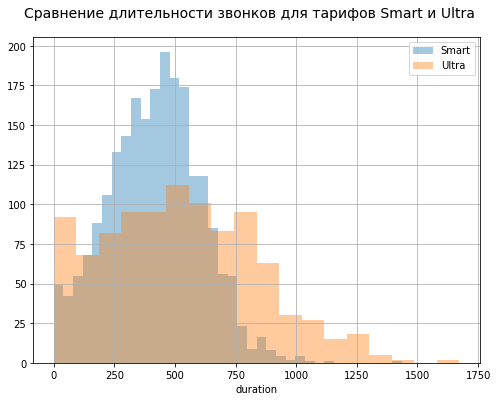

In [37]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_smart['duration'], kde=False, ax=ax)
sns.distplot(df_ultra['duration'], kde=False, ax=ax)
plt.suptitle('Сравнение длительности звонков для тарифов Smart и Ultra', size=14, y=0.95); 
plt.grid(True)
plt.legend(['Smart', 'Ultra'])
plt.show()

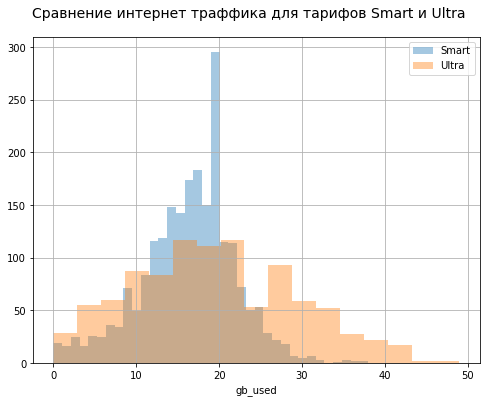

In [38]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_smart['gb_used'], kde=False, ax=ax)
sns.distplot(df_ultra['gb_used'], kde=False, ax=ax)
plt.suptitle('Сравнение интернет траффика для тарифов Smart и Ultra', size=14, y=0.95); 
plt.grid(True)
plt.legend(['Smart', 'Ultra'])
plt.show()

In [50]:
df_smart[df_smart['gb_used']==20]

duration  calls  messages  gb_used tariff             city  \
user_id month                                                               
1002    8         289.0   42.0      13.0     20.0  smart      Стерлитамак   
1006    7         316.0   49.0       0.0     20.0  smart        Ульяновск   
        10        267.0   44.0       0.0     20.0  smart        Ульяновск   
1009    10        213.0   28.0      15.0     20.0  smart            Пермь   
1015    7         556.0   79.0      90.0     20.0  smart        Челябинск   
...                 ...    ...       ...      ...    ...              ...   
1490    6         330.0   48.0      50.0     20.0  smart           Москва   
1492    8         603.0   78.0      15.0     20.0  smart  Санкт-Петербург   
1496    6         555.0   74.0      35.0     20.0  smart          Вологда   
1497    12        545.0   71.0      17.0     20.0  smart        Челябинск   
1489    10          0.0    NaN      21.0     20.0  smart  Санкт-Петербург   

               revenue  
user_id month           
1002    8       1550.0  
1006    7       1550.0  
        10      1550.0  
1009    10      1550.0  
1015    7       1838.0  
...                ...  
1490    6       1550.0  
1492    8       1859.0  
1496    6       1715.0  
1497    12      1685.0  
1489    10      1550.0  

[140 rows x 7 columns]

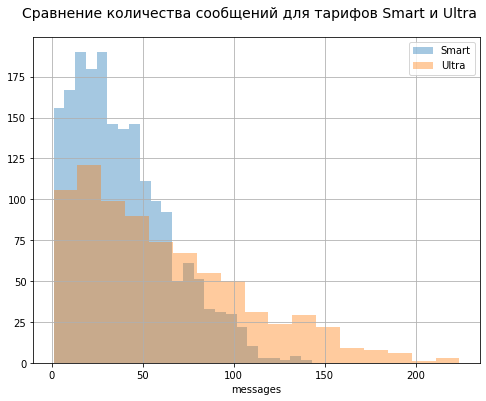

In [39]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_smart.query('messages > 0')['messages'], kde=False, ax=ax)
sns.distplot(df_ultra.query('messages > 0')['messages'], kde=False, ax=ax)
plt.suptitle('Сравнение количества сообщений для тарифов Smart и Ultra', size=14, y=0.95); 
plt.grid(True)
plt.legend(['Smart', 'Ultra'])
plt.show()

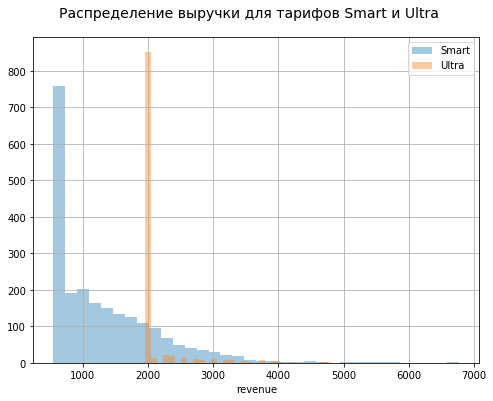

In [40]:
fig, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_smart['revenue'], kde=False, ax=ax)
sns.distplot(df_ultra['revenue'], kde=False, ax=ax)
plt.suptitle('Распределение выручки для тарифов Smart и Ultra', size=14, y=0.95); 
plt.grid(True)
plt.legend(['Smart', 'Ultra'])
plt.show()

#### Вывод

Дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. Более половины пользователей тарифа Смарт превышает установленный в рамках тарифа лимит по использованию траффика, в то время как пользователи тарифа Ультра имеют больше свободы при использовании услуг оператора, оставая в рамках доступных лимитов установленных тарифным планом. 

### Шаг 4. Проверка гипотез

**Гипотеза 1.** Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;

Нулевая гипотеза $H_0$ для первой задачи гласит: "Средняя выручка пользователей тарифов «Ультра» равна средней выручке пользователей тарифа «Смарт»".

Альтернативная гипотеза $H_1$ - средние выручки пользователей тарифов Смарт и Ультра не равны

In [41]:
df_ultra['revenue'].describe()

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue, dtype: float64

In [42]:
df_smart['revenue'].describe()

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: revenue, dtype: float64

Сравнивая средние значения выручки по обоим тарифам, мы видим, что средние значения различаются почти в два раза. 


Для оценки гипотезы будем применять тест Стюдента. 

In [43]:
alpha=0.01
results = st.ttest_ind(
    df_ultra['revenue'], 
    df_smart['revenue'], 
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


#### Вывод

**Гипотеза 2.** Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза $H_1$ для второй задачи - средняя выручка пользователей из Москвы равна средней выручке пользоваталей из других регионов

Альтернативная гипотеза $H_0$ - Средние выручка пользователей из Москвы не равна средней выручке пользоваталей из других регионов

In [44]:
moscow = df.query('city == "Москва"')['revenue']
all_regions = df.query('city != "Москва"')['revenue']

In [45]:
alpha=0.05
results = st.ttest_ind(
    moscow, 
    all_regions, 
    equal_var=False)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


In [46]:
df.query('city == "Москва"')['revenue'].describe()

count     611.000000
mean     1546.713584
std       752.088071
min       550.000000
25%       780.500000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: revenue, dtype: float64

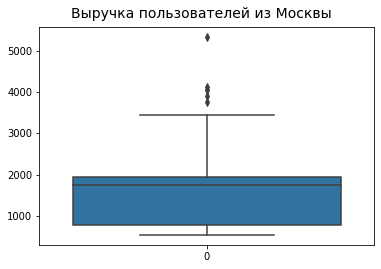

In [47]:
sns.boxplot(data=df.query('city == "Москва"')['revenue'])
plt.suptitle('Выручка пользователей из Москвы', size=14, y=0.95); 
plt.show()

In [48]:
df.query('city != "Москва"')['revenue'].describe().describe()

count       8.000000
mean     2067.465497
std      2020.118719
min       550.000000
25%       794.090814
50%      1553.968114
75%      2113.250000
max      6770.000000
Name: revenue, dtype: float64

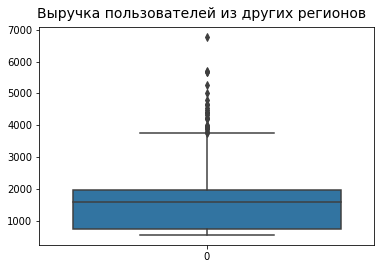

In [49]:
sns.boxplot(data=df.query('city != "Москва"')['revenue'])
plt.suptitle('Выручка пользователей из других регионов', size=14, y=0.95); 
plt.show()

#### Вывод 

Доходы оператора в Москве практически не отличаются от других регионов. По результатам статистического теста не удалось опровернгнуть гипотезу, что средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Шаг 5. Выводы

В ходе проделанной работы было выполнено:

1. Просмотрена каждая таблица
2. Составлена общая таблица данных о пользователях сети
3. Заполнены пропуски и сменены типы данных для столбцов
4. Проведен сравнительный анализ пользователей тарифов
5. Проверены выдвинутые гипотезы

В среднем пользователи тарифа Смарт тратят на связь 1234 рубля, в то время как пользователи тарифа Ультра тратят 2060, что говорит о том, что траты пользователей тарифа Смарт в среднем значительно превосходят расходы по абонентской плате - обусловленно тем, что пользователем Смарта не хватает включенных в пакет услуг, в частности, интернет траффика, в то время как пользователи Ультра тарифа наоборот не используют возможности тарифа в полном объеме. 

Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,503). 